# Project

In [31]:
import tdmclient.notebook
await tdmclient.notebook.stop()

ValueError: Function <function _pre_run_cell at 0x0000026FB0473130> is not registered as a pre_run_cell callback

In [33]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
import tdmclient.notebook
await tdmclient.notebook.start()
#from tdmclient import ClientAsync, aw

In [50]:
# parametres
speed_r = 125
time_rotation = 7*speed_r/125

speed_f = 125
stop = 0

MIN_DIST = 30
ANGLE_TOLERANCE = 0.35

def motors_async(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }


@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    """
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

#input : angle to change the trajectory
@tdmclient.notebook.sync_var
def orientation (angle):  
 #   global motor_left_target, motor_right_target
    if(angle >= 0 ):
        motors(-speed_r, speed_r)
    else:
        motors(speed_r, -speed_r)
    #if angle < 0:
    #    motors(speed_r, stop)
    #else :
    #    motors(stop, speed_r)
    #    
    time.sleep(0.01)
    

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

#input : coordinates of two different points 
#return the distance between two points 
def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))
    return dist

In [51]:
def mouving (node,video_capture, path, x0, y0, theta0, periode=0.01):
    teta = np.zeros(np.shape(path)[0])
   
    goalx = path[0][0]
    goaly = path[0][1]
    
    i = 0
    x_pense = x0
    y_pense = y0
    teta_pense = theta0
    
    kx = 0
    ky = 0
    kteta = 0
   
    print('x =', x_pense, 'y =', y_pense, 'teta =', teta_pense)

    while i < np.shape(path)[0]-1:
        #[kx, ky, kteta] = kalman()
        
        ret, frame = video_capture.read()
        
        if ret == True:
            position_measure = []
            position_measure, position_contour,_ = computer_vision(frame, 'robot', False)
            position_measure = position_measure[0]
            if position_measure is not None:
                _, theta_measure = get_robot_position(frame, position_measure, position_contour)
            position_measure = invert_coordinates(position_measure)
            [kx, ky, kteta] = [position_measure[0], position_measure[1], theta_measure]
        else:
            [kx, ky, kteta] = [x_pense, y_pense, teta_pense]
        print(ret, kx, ky, kteta)
        
        teta[i] = math.atan2((goaly - ky), (goalx - kx)) #change angle according to kalman
        if np.abs(teta[i] + kteta) > ANGLE_TOLERANCE:
            orientation(teta[i] - kteta)

        dist = distance (goalx, goaly, kx, ky)
        if (dist < MIN_DIST):
            print('i = ',i)
            i = i + 1
            goalx = path[i][0]
            goaly = path[i][1]
            motors(speed_f, speed_f)            
            x_pense = path[i-1][0]
            y_pense = path[i-1][1]
            vec1 = [np.cos(teta[i-1]), np.sin(teta[i-1])]
            vec2 = [goalx - x_pense, goaly - y_pense]
            angle = -get_angle_between(vec1, vec2)
            
            teta_pense = angle + teta[i-1]
            if np.abs(teta[i] + kteta) > ANGLE_TOLERANCE:
                orientation(angle)
        else :
            motors(speed_f, speed_f)
            x_pense = kx + speed_f * periode * np.cos(teta[i])
            y_pense = ky + speed_f * periode * np.sin(teta[i])
            teta_pense = teta[i]
            kteta = teta[i]
            
            time.sleep(periode)
        motors(stop, stop)
   
    
    # move the robot to the last point
    
    while x_pense!=path[i][0] or y_pense!=path[i][1]:
        #[kx, ky, kteta] = kalman()
        [kx, ky, kteta] = [x_pense, y_pense, teta_pense]
        teta[i] = math.atan2((goaly - ky), (goalx - kx))
        print('kx= ',kx,'ky = ', ky,'goalx = ', goalx,'goaly = ',goaly)
        dist = distance(goalx, goaly, kx, ky)
        print('dist = ', dist)
        if (dist < (speed_f * periode)):
            motors(speed_f, speed_f)
            #node.send_set_variables(motors_async(speed_f, speed_f))
            time.sleep(dist/(speed_f/3))
            x_pense=path[i][0]
            y_pense=path[i][1]
        else :
            motors(speed_f, speed_f)
            #node.send_set_variables(motors_async(speed_f, speed_f))
            x_pense = kx + speed_f * periode * np.cos(teta[i])
            y_pense = ky + speed_f * periode * np.sin(teta[i])
            time.sleep(periode)
            
    motors(stop, stop)
    #node.send_set_variables(motors(0,0))

# Main 

1
2
3
[204 346] [1137  540]


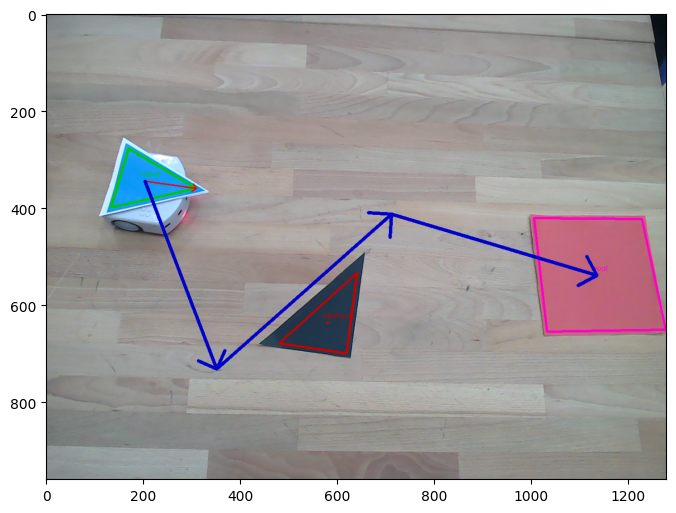

In [56]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
fig, ax = plt.subplots(figsize=(8,8))
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)


if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    print(start, goal)
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 

    for i in range(len(path)):
        path[i] = pixel_to_metric(path[i])
    start = pixel_to_metric(start)
    
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [58]:
#ret, frame = video_capture.read()
#print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#cv2.imwrite('frame.jpeg', frame)

motors(stop, stop)

In [57]:
for p in path:
    p = invert_coordinates(p)

start = invert_coordinates(start)
start = pixel_to_metric(start)

mouving(node, video_capture, path, robot[0], robot[1], robot[2], periode=0.05)

x = 204 y = 346 teta = 0.14057605140955787
True 204 614 0.14057605140955787
True 204 614 0.14057605140955787
True 204 614 0.14057605140955787
True 207 613 0.14057605140955787
True 211 612 0.14981245657289735
True 212 613 0.14981245657289735
True 215 611 0.16977827396833844
True 216 611 0.18822150530477075
True 218 610 0.17901527702148565
True 221 609 0.19924398658020598
True 223 608 0.20846521837998772
True 226 607 0.22679884805388587
True 228 606 0.22679884805388587
True 231 605 0.23811378241001133
True 234 605 0.24726176418276047
True 237 603 0.2540077631265936
True 241 602 0.2495869254369846
True 244 602 0.2587708919636976
True 247 600 0.26791042242333973
True 249 599 0.2978030374744346
True 252 598 0.3068262894065572
True 253 597 0.31874756042064445
True 254 596 0.33667481938672716
True 256 595 0.348771003583907
True 259 594 0.3699060674565577
True 262 593 0.3911254469690291
True 265 590 0.37874581555108416
True 267 590 0.3911254469690291
True 270 588 0.4124104415973873
True 273 58

KeyboardInterrupt: 